# PW 2 - Bayesian analysis with MRF
For this part we will perform the binary classification of a grayscale image **_Iobservee_** (image of the observations, realization $y$ of the field $Y$) using a Markovian model.

In this ideal case, we are given the ideal solution $x$ (binary image **_IoriginalBW_**), realization of the field of classes $X$, which will be used to evaluate the quality of the solution $\hat{x}$ that we will have obtained. (NB: In practice usually, we don't have access to $x$).

In this part we will use the **_display_** function to visualize the images.

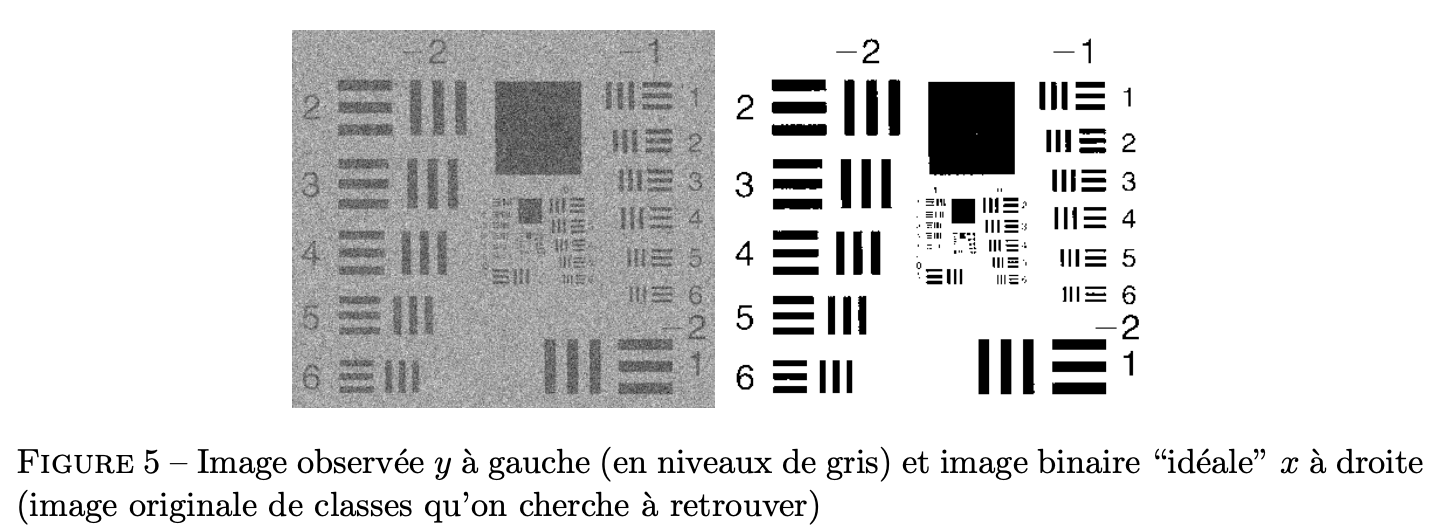

In [121]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import skimage
from skimage import img_as_float, img_as_ubyte

from scipy.stats import norm


In [19]:
COLOR_01 = "#c44e52" # rgb(196,78,82)
COLOR_02 = "#4c72b0" # rgb(76,114,176)
COLOR_03 = "#231f20" # rgb(35, 31, 32)
COLOR_04 = "#b50c36" # rgb(181, 12, 54)
COLOR_05 = "#bdbcbc" # rgb(189, 188, 188)
COLOR_06 = "#886081" # 136  96 129


In [3]:
im_obs = skimage.io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Iobservee.png")
im_obs = img_as_float(im_obs)
im_ori = skimage.io.imread('https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/IoriginaleBW.png')
im_ori = img_as_float(im_ori)

The objective is to estimate $x$ from y using a prior on $P(X)$ in the form of a Markovian model.
We note $x_s$ the class of the pixel $s$ (that we are looking for), and $y_s$ the observed gray level. The objective is to use a global model on the random field $X$ to classify the image. As we have seen in class, this amounts to minimizing the following energy:

$$U(x|y)=\sum_s -ln(P(Y_s=y_s |X_s=x_s))+\sum_c U_c(x_s, s\in c)$$

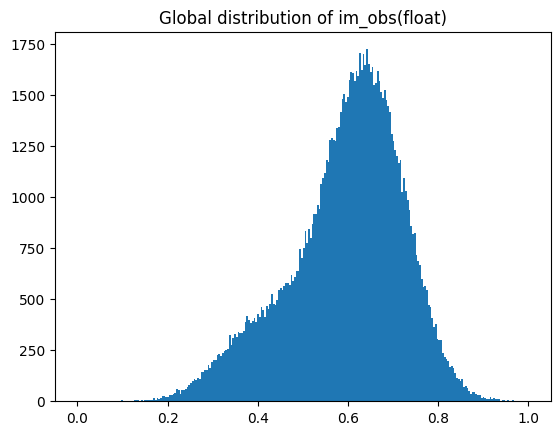

In [4]:
#study of the global distribution of the image
#display of the histogram of the image
%matplotlib inline
plt.figure()
plt.hist(im_obs.ravel(),range=[0,np.max(im_obs)],bins=256)
plt.title("Global distribution of im_obs(float)")
plt.show()

## 1. Analysis of the gray level distributions
In this part, we learn the probabilities $P(Y_s=y_s |X_s)$, that is to say $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. This is equivalent to studying the histogram of gray levels of pixels that are in class 0 and pixels that are in class 1.  


To perform this training, we need to select pixels belonging to class 0 on the one hand (dark area of the observed image), and pixels belonging to class 1 on the other hand (light area of the observed image).

We can select pixels manually, using the command `v0=I[i1:i2,j1:j2]` in Python which puts in a vector all the values of the pixels of the image $I$ included between the indices $i1$ and $i2$ (rows), and $j1$ and $j2$ (columns).

In [22]:
crop_classe0 = im_obs[50:110, 180:240]
crop_classe1 = im_obs[240:300, 140:200]

m0=np.mean(crop_classe0)
var0=np.var(crop_classe0)
std0 = np.std(crop_classe0)
x0 = np.linspace(0, 1, 1000)
y0 = norm.pdf(x0, m0, std0)


m1=np.mean(crop_classe1)
var1=np.var(crop_classe1)
std1 = np.std(crop_classe1)
x1 = np.linspace(0, 1, 1000)
y1 = norm.pdf(x1, m1, std1)




Text(0, 0.5, 'Probability')

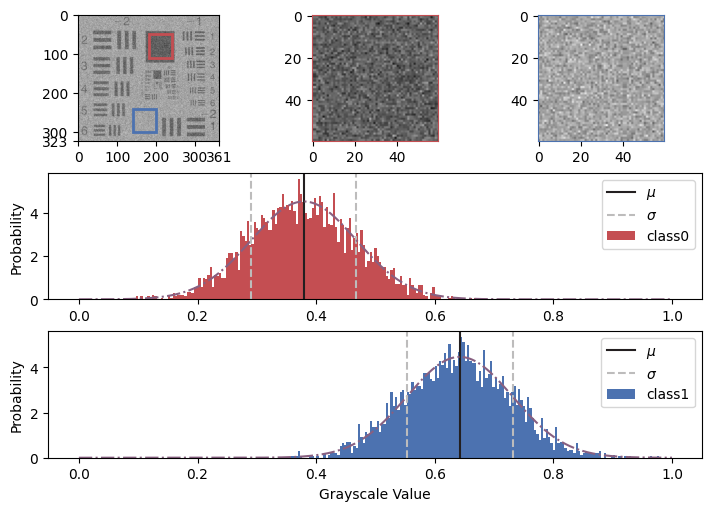

In [23]:
%matplotlib inline
gray_opts = {
    "vmin": 0,
    "vmax": 1,
    "cmap": "gray"
}
fig, axs = plt.subplots(figsize=(7,5), constrained_layout=True)
axs.set_axis_off()
gs = fig.add_gridspec(3, 3)
ax = []

ax.append(fig.add_subplot(gs[0,0]))
ax[-1].imshow(im_obs, **gray_opts)
ax[-1].add_patch(
    Rectangle(
        (180, 50),  
        60, 60,
        edgecolor=COLOR_01,
        facecolor="none",
        lw=2
    )
)
ax[-1].add_patch(
    Rectangle(
        (140, 240),  
        60, 60,
        edgecolor=COLOR_02,
        facecolor="none",
        lw=2
    )
)
ax[-1].set_xticks(np.append(np.arange(0, im_obs.shape[1], 100), im_obs.shape[1]))
ax[-1].set_yticks(np.append(np.arange(0, im_obs.shape[0], 100), im_obs.shape[0]))


# crop_classe0 = im_obs[50:110, 180:240]
# crop_classe1 = im_obs[240:300, 140:200]

ax.append(fig.add_subplot(gs[0,1]))
ax[-1].imshow(crop_classe0, **gray_opts)
ax[-1].spines['bottom'].set_color(COLOR_01)
ax[-1].spines['top'].set_color(COLOR_01)
ax[-1].spines['right'].set_color(COLOR_01)
ax[-1].spines['left'].set_color(COLOR_01)


ax.append(fig.add_subplot(gs[0,2]))
ax[-1].imshow(crop_classe1, **gray_opts)
ax[-1].spines['bottom'].set_color(COLOR_02)
ax[-1].spines['top'].set_color(COLOR_02)
ax[-1].spines['right'].set_color(COLOR_02)
ax[-1].spines['left'].set_color(COLOR_02)


ax.append(fig.add_subplot(gs[1, :]))
counts, bins = np.histogram(crop_classe0.ravel(), bins=256, range=[0,1])
pr = counts / len(crop_classe0.ravel()) / np.diff(bins)

ax[-1].bar(bins[:-1], pr, width=np.diff(bins), edgecolor="none", facecolor=COLOR_01)
ax[-1].axvline(m0, color=COLOR_03)
ax[-1].axvline(m0+std0, color=COLOR_05, linestyle="--")
ax[-1].legend(["$\mu$", "$\sigma$", "class0"])
ax[-1].plot(x0, y0, linestyle="dashdot", color=COLOR_06)
ax[-1].axvline(m0-std0, color=COLOR_05, linestyle="--")
ax[-1].set_ylabel("Probability")
# ax[-1].hist(crop_classe0.ravel() / len(crop_classe0.ravel()),range=[0,1],bins=256, edgecolor="none", facecolor=COLOR_01, density=True)


ax.append(fig.add_subplot(gs[2, :]))
counts, bins = np.histogram(crop_classe1.ravel(), bins=256, range=[0,1])
pr = counts / len(crop_classe1.ravel()) / np.diff(bins)
ax[-1].bar(bins[:-1], pr, width=np.diff(bins), edgecolor="none", facecolor=COLOR_02)
ax[-1].axvline(m1, color=COLOR_03)
ax[-1].axvline(m1+std1, color=COLOR_05, linestyle="--")
ax[-1].legend(["$\mu$", "$\sigma$", "class1"])
ax[-1].plot(x1, y1, linestyle="dashdot", color=COLOR_06)
ax[-1].axvline(m1-std1, color=COLOR_05, linestyle="--")
ax[-1].set_ylabel("Probability")
ax[-1].set_xlabel("Grayscale Value")
ax[-1].set_ylabel("Probability")

### Q1
What are the distributions followed by the grey levels in these two classes? Give the means and variances of the two classes that you have estimated.

### A1

In [7]:
print(f"mean0 = {m0}, var0 = {var0}")
print(f"mean0 = {m1}, var1 = {var1}")

mean0 = 0.37919063180827883, var0 = 0.007820295839444468
mean0 = 0.6421535947712418, var1 = 0.007965852866418897


---

### Q2
In the following, the variances will be assumed to be equal in order to simplify the energy expressions.

Suppose that we do not use a Markov model on $X$ and that we classify a pixel only according to its grey level by comparing $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. Show that this amounts to thresholding the image and give the value of the optimal threshold as a function of the parameters found previously (we say that we are doing a classification by punctual maximum likelihood).

### A2

The variances are assumed to be equal, we set then: $\sigma^2 = (\sigma_0^2 + \sigma_1^2)/2$ : 

In [28]:
var = 0.5 * (var0 + var1)
print(var)

0.007893074352931684


$$
P(Y | X_s=0) \sim \mathcal{N}(0.379, 0.079) \\

P(Y | X_s=1) \sim \mathcal{N}(0.642, 0.079) \\

P(Y | X_s=0) > P(Y | X_s=1) \Rightarrow Y_s < \frac{\mu_0 + \mu_1}{2}
$$

In [31]:
threshold = (m0 + m1) /2
# Set the threshold for classification in the ML sense and display the image
im_bin=im_obs.copy()
im_bin[im_obs > threshold] = 1
im_bin[im_obs < threshold] = 0
print(threshold)

0.5106721132897603


In [64]:
threshold * 256

130.73206100217863

Text(0.5, 1.0, 'Two histograms of conditional distributions')

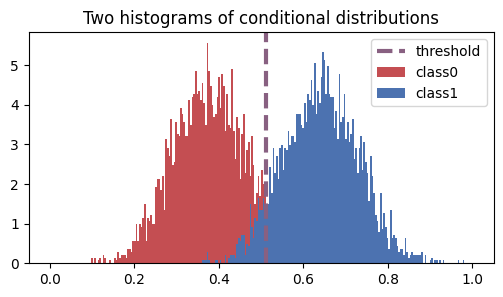

In [65]:
fig = plt.figure(figsize=(6,3))
plt.hist(crop_classe0.ravel(), bins=256, range=(0,1), density=True, edgecolor="none", facecolor=COLOR_01)
plt.hist(crop_classe1.ravel(), bins=256, range=(0,1), density=True, edgecolor="none", facecolor=COLOR_02)
plt.axvline(threshold, color=COLOR_06, linestyle="--", linewidth=3)
plt.legend(["threshold", "class0", "class1",])
plt.title("Two histograms of conditional distributions")


Text(0.5, 1.0, 'im_ori')

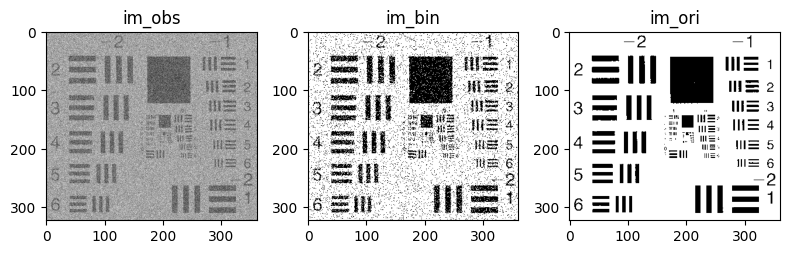

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), tight_layout=True)
axs[0].imshow(im_obs, **gray_opts)
axs[0].set_title("im_obs")
axs[1].imshow(im_bin, **gray_opts)
axs[1].set_title("im_bin")
axs[2].imshow(im_ori, **gray_opts)
axs[2].set_title("im_ori")

---

### Q3
From the results found for $P(Y_s=y_s |X_s)$, write the likelihood energy (data attachment): $$U_{attdo}=\sum_s -ln(P(Y_s=y_s |X_s=x_s))$$

### A3
on document

---

## 2 Ising model for regularisation and energies
To improve the thresholding results, it is necessary to introduce a regularisation (global prior model).

### Q4
Consider the function $\Delta(x_s,x_t)=0$ if $x_s=x_t$, and $\Delta(x_s,x_t)=1$ otherwise. Write the second-order clique potential for this Ising model as a function of $\Delta(x_s,x_t)$ where $x_s$ and $x_t$ are the classes of neighbouring pixels $s$ and $t$ in 4-connexity and the regularisation parameter $\beta$. This model will be 0 when the two neighbouring pixels are equal and $+\beta$ otherwise.
Write the global energy of the whole field and the local conditional energy for a site 𝑠 using the results previously established for the data attachment energy and the regularization energy defined previously.

Reminder: the global energy contains all the cliques in the image, the local conditional energy at a site 𝑠 contains only the cliques that contain 𝑠.

Tip: the energy is defined to within one additive constant and one multiplicative constant (the minimum of K+K'U is equivalent to the minimum of U). It is better to simplify the writing of the energy as much as possible in order to do the programming afterwards.

### A4
- _global energy_:

- _local conditional energy_:

on document

---

### Q5
Write the local conditional energies for classes 0 and 1 of the central pixel, using the following local neighbourhood configuration: neighbours in states 0, 1, 1, 1, and assuming that the grey level of the pixel is $y_s=105$, and using the mean and variance values found previously.

### A5

on doc

---

### Q6
In which class will this pixel be put if it is assigned the class that locally minimises energy?


### A6

on doc

---

### Q7
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is 0 ?

### A7

on doc

---

### Q8
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is $+\infty$ ?

### A8

on doc

---

### Q9
How will the solution vary when $\beta$ increases ? Comment on the interest of this Markovian model.

### A9

on doc

---

## 3. Optimisation by ICM algorithm
We will optimise the global energy defined above, using the ICM (Iterated Conditional Modes) algorithm which consists of minimising the local conditional energy of the pixels one after the other, starting from a good initialisation of the classes. This algorithm converges to a local minimum but is very fast.  

Complete the **iter_icm** function to program the ICM, taking into account the data attachment term you have learned.

### ICM function
Using what you did for the Gibbs sampler, complete the following function to perform one iteration of the Iterated Conditional Modes algorithm (one pass over all pixels in the image).

In [89]:
def iter_icm(im_bin,im_toclass,beta_reg,m0,m1):
    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):
            # do not change these indices they allow access to neighboring pixels
            i1=(i-1)%im_bin.shape[0]
            i2=(i+1)%im_bin.shape[0]
            j1=(j-1)%im_bin.shape[1]
            j2=(j+1)%im_bin.shape[1]

            # energy computation if the pixel is put in class 0
            U0 = (im_toclass[i][j] - m0)**2 + beta_reg * (
                im_bin[i1][j] + im_bin[i2][j] + im_bin[i][j1] + im_bin[i][j2]
            )

            # energy computation if the pixel is put in class 1
            U1= (im_toclass[i][j] - m1)**2 + beta_reg * (4 - (
                im_bin[i1][j] + im_bin[i2][j] + im_bin[i][j1] + im_bin[i][j2]
            ))

            if (U0 > U1):
                im_bin[i,j] = 1
            else :
                im_bin[i,j] = 0

    return im_bin


### Q10
What do you suggest to have a good initialization of the solution? Justify your answer.

### A10

Implement the ICM and study the influence of $\beta$.

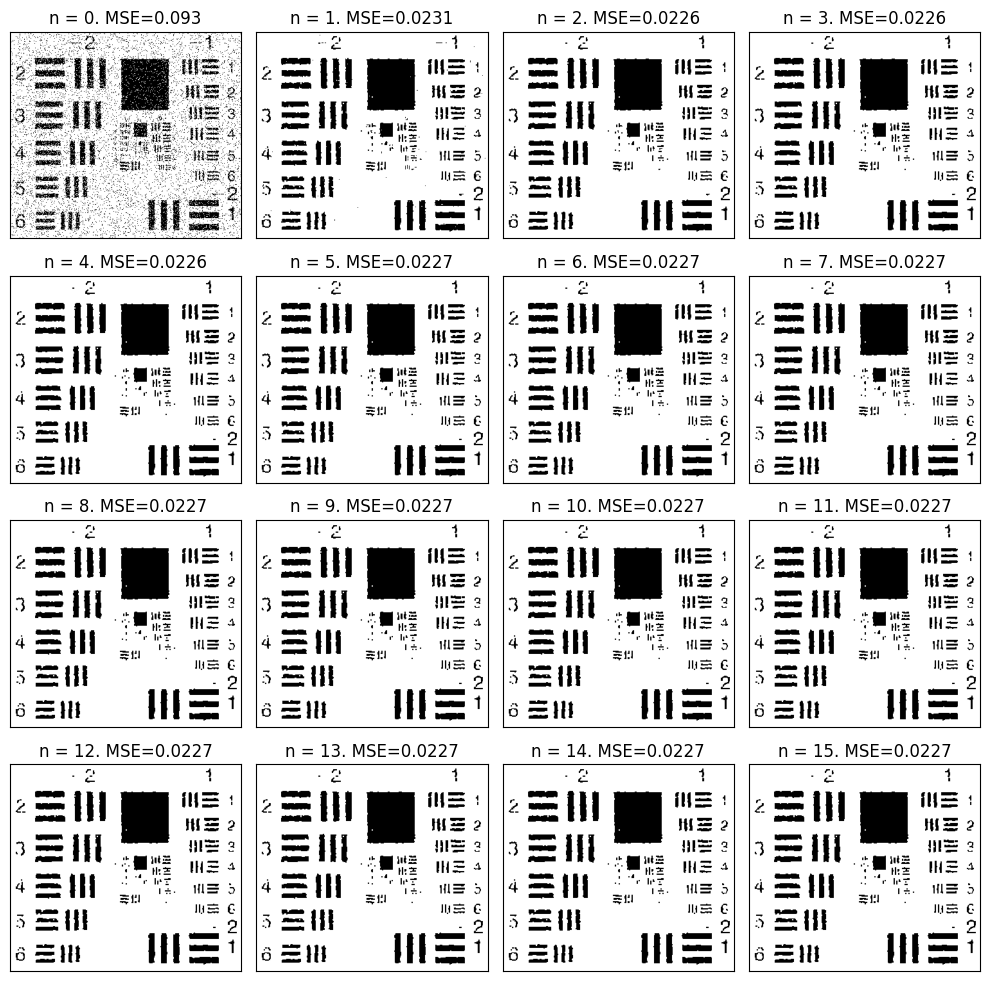

In [113]:
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg = 0.1
#initialise the binary image of the classes
im_bin=im_obs.copy()
im_bin[im_obs > threshold] = 1
im_bin[im_obs < threshold] = 0

# program a loop in which we call iter_icm
# and display the class image as iterations are performed
im = im_bin.copy()

fig, axs = plt.subplots(4, 4, figsize=(10,10), tight_layout=True)
axsf = axs.flatten()
axsf[0].imshow(im, **gray_opts)
mse = np.mean(np.square(im - im_ori))
axsf[0].set_title(f"n = {0}. MSE={mse:.3f}")

for n in range(15):
    ax = axsf[n+1]
    im = iter_icm(im, im_obs, beta_reg=beta_reg, m0=m0, m1=m1)
    ax.imshow(im, **gray_opts)
    mse = np.mean(np.square(im - im_ori))
    ax.set_title(f"n = {n+1}. MSE={mse:.4f}")

for ax in axsf:
    ax.set_xticks([])
    ax.set_yticks([])

In [98]:
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_regs = [0.001, 0.01, 0.1, 1]
#initialise the binary image of the classes
im_bin=im_obs.copy()
im_bin[im_obs > threshold] = 1
im_bin[im_obs < threshold] = 0

# program a loop in which we call iter_icm
# and display the class image as iterations are performed

mses = []
for beta_reg in beta_regs:

    im = im_bin.copy()
    for n in range(15):
        im = iter_icm(im, im_obs, beta_reg=beta_reg, m0=m0, m1=m1)
    mse = np.mean(np.square(im - im_ori))
    mses.append(mse)


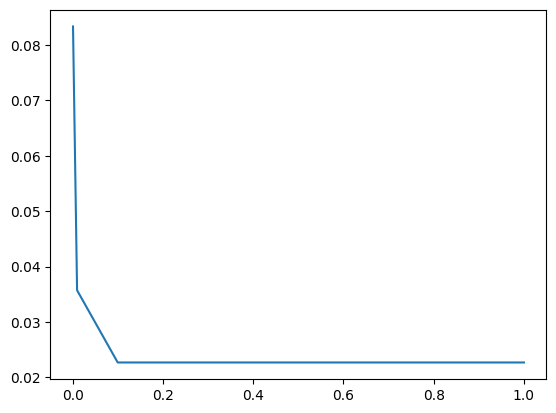

In [99]:
plt.plot(beta_regs, mses)

---


### Q12
With what value of $\beta$ do you get a good solution (i.e. the closest to the given "ideal" image **IoriginaleBW.png**). Compare this result with the result of the optimal thresholding.

### A12

---

### Q13
Try with other initialisations (with a constant image, with a random image). Comment on their influence.

### A13

In [115]:
im_bin

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

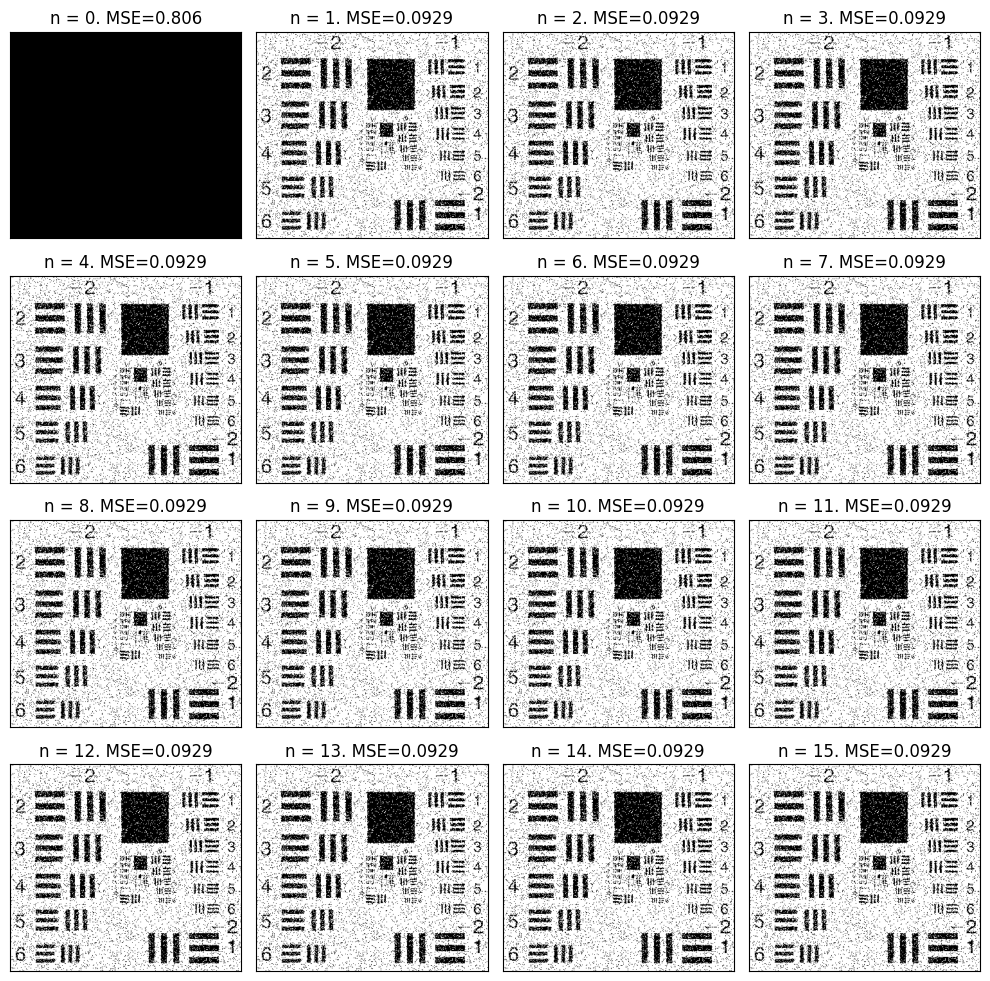

In [116]:
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg = 0.00001
#initialise the binary image of the classes
im_bin=np.zeros_like(im_obs)

# program a loop in which we call iter_icm
# and display the class image as iterations are performed
im = im_bin.copy()

fig, axs = plt.subplots(4, 4, figsize=(10,10), tight_layout=True)
axsf = axs.flatten()
axsf[0].imshow(im, **gray_opts)
mse = np.mean(np.square(im - im_ori))
axsf[0].set_title(f"n = {0}. MSE={mse:.3f}")

for n in range(15):
    ax = axsf[n+1]
    im = iter_icm(im, im_obs, beta_reg=beta_reg, m0=m0, m1=m1)
    ax.imshow(im, **gray_opts)
    mse = np.mean(np.square(im - im_ori))
    ax.set_title(f"n = {n+1}. MSE={mse:.4f}")

for ax in axsf:
    ax.set_xticks([])
    ax.set_yticks([])

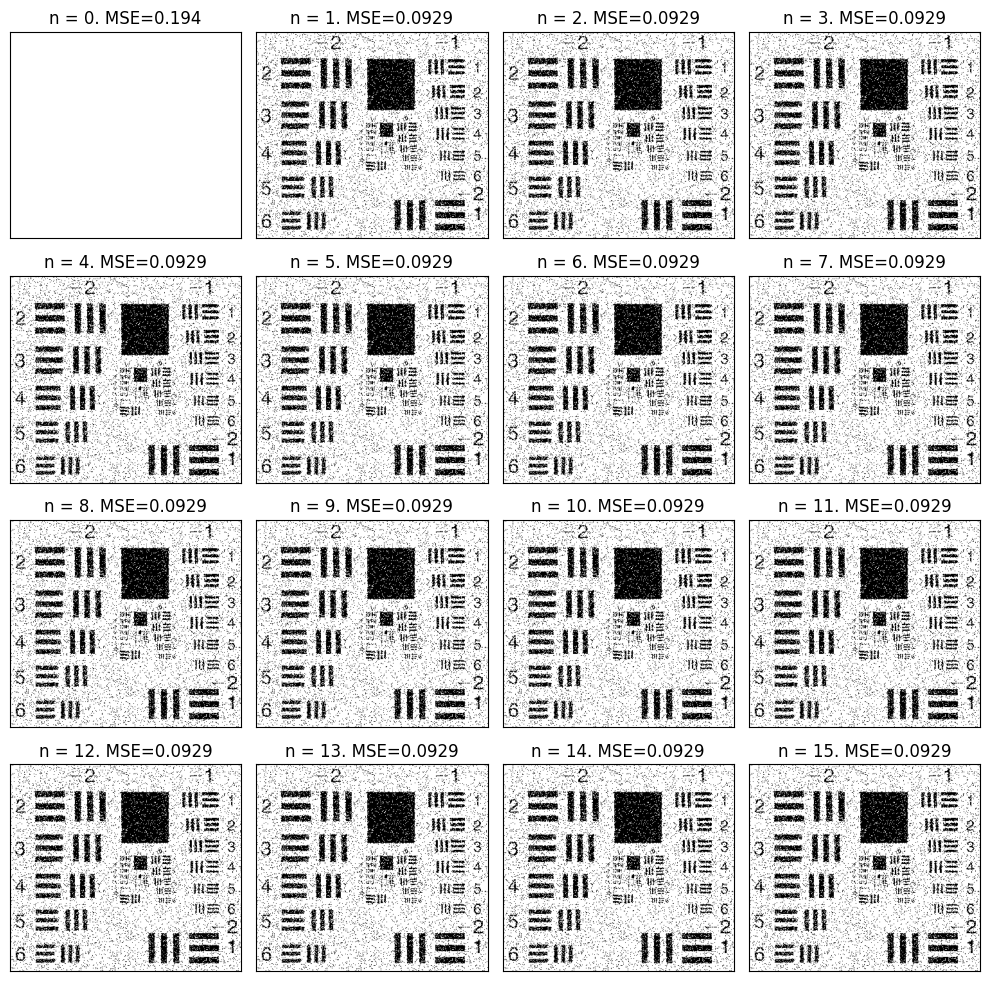

In [119]:
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg = 0.00001
#initialise the binary image of the classes
im_bin=np.ones_like(im_obs)

# program a loop in which we call iter_icm
# and display the class image as iterations are performed
im = im_bin.copy()

fig, axs = plt.subplots(4, 4, figsize=(10,10), tight_layout=True)
axsf = axs.flatten()
axsf[0].imshow(im, **gray_opts)
mse = np.mean(np.square(im - im_ori))
axsf[0].set_title(f"n = {0}. MSE={mse:.3f}")

for n in range(15):
    ax = axsf[n+1]
    im = iter_icm(im, im_obs, beta_reg=beta_reg, m0=m0, m1=m1)
    ax.imshow(im, **gray_opts)
    mse = np.mean(np.square(im - im_ori))
    ax.set_title(f"n = {n+1}. MSE={mse:.4f}")

for ax in axsf:
    ax.set_xticks([])
    ax.set_yticks([])

### Simulated annealing
Program the **echan_r** function of the simulated annealing which allows to update an image by sampling with the Gibbs distribution a posteriori with a fixed temperature T.  

In [127]:
def echan_r(im_bin,im_toclass,beta_reg,m0,m1,T):

    i=0;
    j=0;

    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):

            i1=(i-1)%im_bin.shape[0]
            i2=(i+1)%im_bin.shape[0]
            j1=(j-1)%im_bin.shape[1]
            j2=(j+1)%im_bin.shape[1]

            # energy computation if the pixel is put in class 0
            U0 = (im_toclass[i][j] - m0)**2 / 2 / var + beta_reg * (
                im_bin[i1][j] + im_bin[i2][j] + im_bin[i][j1] + im_bin[i][j2]
            )
            p0=math.exp(-U0 / T)

            # energy computation if the pixel is put in class 1
            U1= (im_toclass[i][j] - m1)**2 / 2 / var  + beta_reg * (4 - (
                im_bin[i1][j] + im_bin[i2][j] + im_bin[i][j1] + im_bin[i][j2]
            ))
            p1 = math.exp(-U1 / T)


            if (p0+p1!=0.):
                if(random.uniform(0,1)<p0/(p0+p1)):
                    im_bin[i,j]=0
                else :
                    im_bin[i,j]=1

    return im_bin

Call the function echan_r iteratively, decreasing the temperature after each update slowly enough.

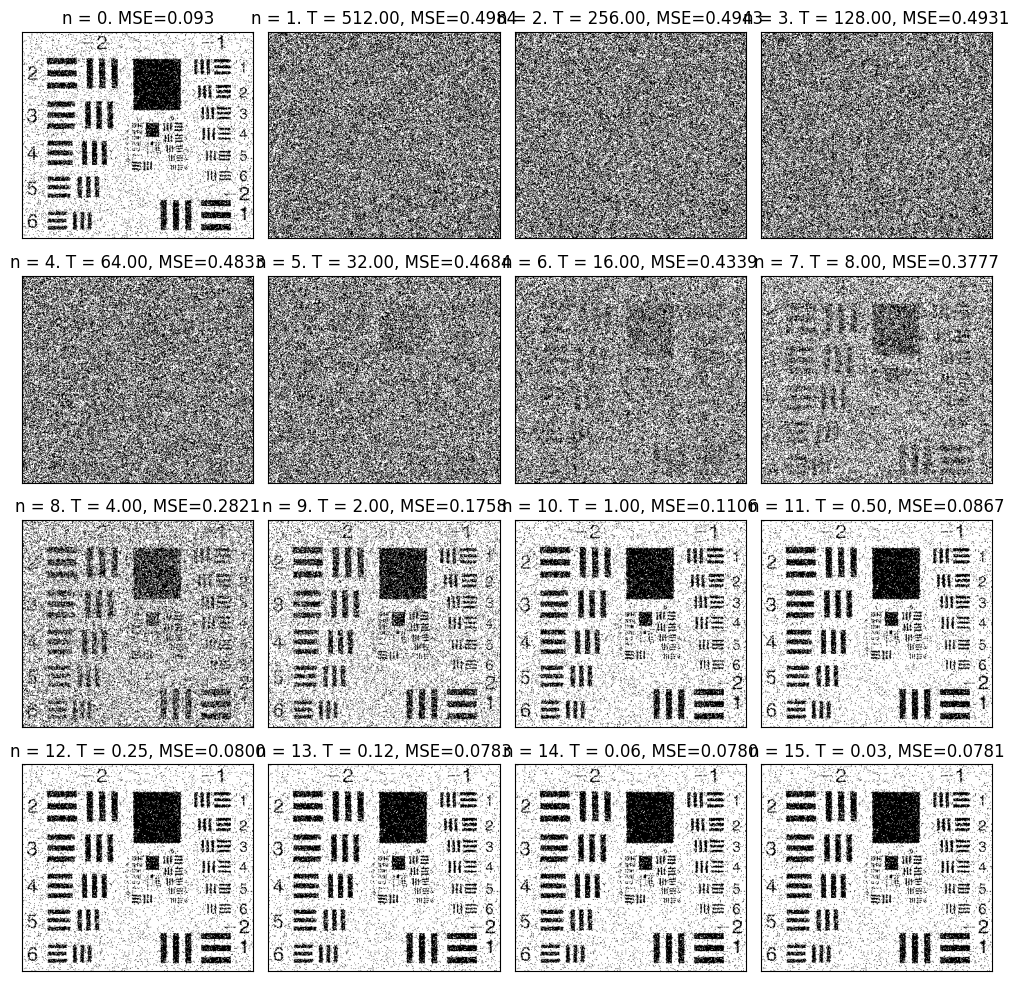

In [138]:
# Program the simulated annealing
#temperature initialization
# initial temperature
T = 1024

# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg = 0.1
#initialise the binary image of the classes
im_bin=im_obs.copy()
im_bin[im_obs > threshold] = 1
im_bin[im_obs < threshold] = 0

# program a loop in which we call iter_icm
# and display the class image as iterations are performed
im = im_bin.copy()

fig, axs = plt.subplots(4, 4, figsize=(10,10), tight_layout=True)
axsf = axs.flatten()
axsf[0].imshow(im, **gray_opts)
mse = np.mean(np.square(im - im_ori))
axsf[0].set_title(f"n = {0}. MSE={mse:.3f}")

for n in range(15):
    ax = axsf[n+1]
    T = T * 0.5
    im = echan_r(im, im_obs, beta_reg=beta_reg, m0=m0, m1=m1, T=T)
    ax.imshow(im, **gray_opts)
    mse = np.mean(np.square(im - im_ori))
    ax.set_title(f"n = {n+1}. T = {T:.2f}, MSE={mse:.4f}")

for ax in axsf:
    ax.set_xticks([])
    ax.set_yticks([])


### Q14
Compare the results obtained by the Iterated Conditional Modes algorithm and by simulated annealing. Do you find the results of the course ?

### A14

on doc

---
---